![FHIR Kindling](assets/kindling_header.png)

<center>Python toolkit for interacting with HL7 FHIR servers and resources</center>

# Why this project was created
- PHT required FHIR project warehouses
- Data transfer between FHIR servers difficult and tedious
- No automatic conversion to tabular format for analysis
- Existing libraries felt slow
- Simplify FHIR data science & engineering tasks



# Features

- Create, Read, Update and Delete resources using a server's REST API
- Resource validation powered by pydantic models
- Transfer resources between FHIR servers
- CSV/Dataframe serialization for resources & bundles
- Synthetic data generation and upload


## In this presentation

- Core feature refresher
- Graph based probabilistic dataset generation
- Resource transfer between servers
- Benchmarks for servers
- Kindling App

## Installation

Install the latest published version from pypi:
```bash
pip install --user fhir-kindling
```
or install the newest version directly from github:
```bash
pip install --user git+https://github.com/migraf/fhir-kindling.git
```

More details can be found in the [documentation]()


In [ ]:
!pip install --upgrade fhir-kindling
!pip install RISE

<center><h2>👨‍💻   How to use the library</h2></center>

## Connecting to a server

- Different auth methods: Basic, Bearer, OIDC
- Configuration of proxies and custom headers

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from fhir_kindling import FhirServer

_ = load_dotenv(find_dotenv())

C:\Users\Michael Graf\tbi\repos\fhir_kindling\fhir_kindling\fhir_server\transfer.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:

fhir_api = "http://localhost:9090/fhir"
server = FhirServer(
    api_address=fhir_api,
)

## Query for resources

Query the server with the `query()` method of the server class.

Three ways to define a query:
- Iteratively build the query on a resource using methods like `where()`, `include()`, `has()`
- Use an existing `query_string` to define the query i.e. `Patient?_id=123"`
- Pass a `FhirQueryParameters` object to the query method

## Iteratively building a query

Start building a query by selecting the base resource first

In [3]:
query = server.query("Patient")
query.query_url

'http://localhost:9090/fhir/Patient?_count=5000&_format=json'

### Querying the server
the query is executed against the server using one of the methods `all()`, `first()`, `limit()`

In [4]:
response = query.all()
response

<QueryResponse(resource=Patient, n=13)>

In [5]:
response = query.limit(5)
response

<QueryResponse(resource=Patient, n=5)>

Accessing the resources in a `QueryResponse` object.

In [6]:
response.resources[0]

Patient(resource_type='Patient', fhir_comments=None, id='DCFPI2LRYF7Y6L2J', implicitRules=None, implicitRules__ext=None, language=None, language__ext=None, meta=Meta(resource_type='Meta', fhir_comments=None, extension=None, id=None, lastUpdated=datetime.datetime(2023, 6, 12, 11, 3, 39, 37000, tzinfo=datetime.timezone.utc), lastUpdated__ext=None, profile=None, profile__ext=None, security=None, source=None, source__ext=None, tag=None, versionId='4', versionId__ext=None), contained=None, extension=None, modifierExtension=None, text=None, active=None, active__ext=None, address=None, birthDate=datetime.date(1939, 2, 9), birthDate__ext=None, communication=None, contact=None, deceasedBoolean=None, deceasedBoolean__ext=None, deceasedDateTime=None, deceasedDateTime__ext=None, gender='female', gender__ext=None, generalPractitioner=None, identifier=None, link=None, managingOrganization=None, maritalStatus=None, multipleBirthBoolean=None, multipleBirthBoolean__ext=None, multipleBirthInteger=None, 

### Adding filter conditions

Filter parameters are added on the fields of the base resource using the `where()` method.

In [9]:
query_2 = server.query("Patient").where("birthdate", "lt", "1990-01-01")
query_2.query_url

'http://localhost:9090/fhir/Patient?birthdate=lt1990-01-01&_count=5000&_format=json'

In [10]:
query_2.all()

<QueryResponse(resource=Patient, n=12)>

### Including related resources

In [11]:
query_3 = query_2.include(resource="Condition", reference_param="subject", reverse=True)
query_3.query_url

'http://localhost:9090/fhir/Patient?birthdate=lt1990-01-01&_revinclude=Condition:subject&_count=5000&_format=json'

In [12]:
resp = query_3.all()
resp

<QueryResponse(resource=Patient, n=12)>

## Working with the response

The response to the query is a `QueryResponse` object.

- The `resources` attribute contains a list of resources of the base resource type returned by the query
- The `included_resources` attribute contains a list of included resources. Each entry in the list represents a list of resources of a certain type


In [13]:
 [resource.resource_type for resource in resp.included_resources]

['Condition']

In [14]:
resp.included_resources[0].resources[0]

Condition(resource_type='Condition', fhir_comments=None, id='DCFPIXWM7Q6NWZ2A', implicitRules=None, implicitRules__ext=None, language=None, language__ext=None, meta=Meta(resource_type='Meta', fhir_comments=None, extension=None, id=None, lastUpdated=datetime.datetime(2023, 6, 12, 11, 2, 55, 513000, tzinfo=datetime.timezone.utc), lastUpdated__ext=None, profile=None, profile__ext=None, security=None, source=None, source__ext=None, tag=None, versionId='2', versionId__ext=None), contained=None, extension=None, modifierExtension=None, text=None, abatementAge=None, abatementDateTime=None, abatementDateTime__ext=None, abatementPeriod=None, abatementRange=None, abatementString=None, abatementString__ext=None, asserter=None, bodySite=None, category=None, clinicalStatus=None, code=CodeableConcept(resource_type='CodeableConcept', fhir_comments=None, extension=None, id=None, coding=[Coding(resource_type='Coding', fhir_comments=None, extension=None, id=None, code='RA01.0', code__ext=None, display='C

## Saving the response

Responses can be saved to a file using the `save()` method of the `QueryResponse` class.
Supported formats are `json`, `xml` (if the query was executed with `xml` format) and `csv`.

In [15]:
path = os.path.join(os.getcwd(), "query_response.json")

resp.save(file_path=path)

In [16]:
with open(path, "r") as f:
    print("".join(f.readlines()[:8]))

{
  "id": "DCFQACHFUYO32KDI",
  "type": "searchset",
  "entry": [
    {
      "fullUrl": "http://localhost:9090/fhir/Patient/DCFPIXVY34SQMPST",
      "resource": {
        "meta": {



## Serializing resources into a pandas dataframe

A response (or any bundle) can be serialized into pandas dataframes.
If the response contains resources of different types, the resources are serialized into separate dataframes for each type.

In [17]:
from fhir_kindling.serde.flatten import flatten_response

dfs = flatten_response(resp)

dfs[0].head()

,resourceType,id,meta_versionId,meta_lastUpdated,name_0_family,name_0_given_0,gender,birthDate
0,Patient,DCFPIXVY34SQMPST,1,2023-06-12 11:02:55.144000+00:00,Jones,Brianna,male,1987-06-13
1,Patient,DCFPIXVY34SQMPSM,1,2023-06-12 11:02:55.144000+00:00,Martinez,Tracey,female,1984-01-28
2,Patient,DCFPI2LVEWAH3V23,6,2023-06-12 11:03:39.091000+00:00,Bennett,Lauren,female,1966-07-03
3,Patient,DCFPIXVY34SQMPSO,1,2023-06-12 11:02:55.144000+00:00,Cordova,William,male,1959-07-09
4,Patient,DCFPIXVY34SQMPSS,1,2023-06-12 11:02:55.144000+00:00,Williams,David,male,1956-12-02


In [18]:
dfs[1].head()

,resourceType,id,meta_versionId,meta_lastUpdated,code_coding_0_system,code_coding_0_code,code_coding_0_display,code_text,subject_reference
0,Condition,DCFPIXWM7Q6NWZ2A,2,2023-06-12 11:02:55.513000+00:00,http://id.who.int/icd/release/11/mms,RA01.0,"COVID-19, virus identified",COVID-19,Patient/DCFPIXVY34SQMPSQ
1,Condition,DCFPIXWM7Q6NWZXE,2,2023-06-12 11:02:55.513000+00:00,http://id.who.int/icd/release/11/mms,RA01.0,"COVID-19, virus identified",COVID-19,Patient/DCFPIXVY34SQMPSK
2,Condition,DCFPIXWM7Q6NWZYE,2,2023-06-12 11:02:55.513000+00:00,http://id.who.int/icd/release/11/mms,RA01.0,"COVID-19, virus identified",COVID-19,Patient/DCFPIXVY34SQMPSM
3,Condition,DCFPIXWM7Q6NWZZB,2,2023-06-12 11:02:55.513000+00:00,http://id.who.int/icd/release/11/mms,RA01.0,"COVID-19, virus identified",COVID-19,Patient/DCFPIXVY34SQMPSO
4,Condition,DCFPIXWM7Q6NWZ23,2,2023-06-12 11:02:55.513000+00:00,http://id.who.int/icd/release/11/mms,RA01.0,"COVID-19, virus identified",COVID-19,Patient/DCFPIXVY34SQMPSS


## Converting a list of resources to a dataframe

Any list of resources (pydantic models or dicts) can be converted to a dataframe using the `flatten()` method.

In [19]:
from fhir_kindling.serde import flatten_resources

# get a list of patient resources
patients = server.query("Patient").limit(100).resources

In [20]:
flatten_resources(patients)

,resourceType,id,meta_versionId,meta_lastUpdated,name_0_family,name_0_given_0,gender,birthDate
0,Patient,DCFPI2LRYF7Y6L2J,4,2023-06-12 11:03:39.037000+00:00,Valdez,Johnathan,female,1939-02-09
1,Patient,DCFPI2LTTE3N3KDN,5,2023-06-12 11:03:39.066000+00:00,Hill,Ryan,male,1941-07-20
2,Patient,DCFPI2LVEWAH3V23,6,2023-06-12 11:03:39.091000+00:00,Bennett,Lauren,female,1966-07-03
3,Patient,DCFPIXVY34SQMPSK,1,2023-06-12 11:02:55.144000+00:00,Hutchinson,Jason,male,1939-06-28
4,Patient,DCFPIXVY34SQMPSL,1,2023-06-12 11:02:55.144000+00:00,MD,Mrs. Renee Wagner,male,1933-01-10
5,Patient,DCFPIXVY34SQMPSM,1,2023-06-12 11:02:55.144000+00:00,Martinez,Tracey,female,1984-01-28
6,Patient,DCFPIXVY34SQMPSN,1,2023-06-12 11:02:55.144000+00:00,Williams,Jennifer,female,1999-05-02
7,Patient,DCFPIXVY34SQMPSO,1,2023-06-12 11:02:55.144000+00:00,Cordova,William,male,1959-07-09
8,Patient,DCFPIXVY34SQMPSP,1,2023-06-12 11:02:55.144000+00:00,Smith,Taylor,female,1923-10-14
9,Patient,DCFPIXVY34SQMPSQ,1,2023-06-12 11:02:55.144000+00:00,Lyons,Jordan,male,1951-05-05


## Additional CRUD operations

All other CRUD operations (and their asynchronous equivalents) are exposed as methods on the `FhirServer` object.

- Create: `add()`, `add_all()`
- Read: `get()`
- Update: `update()`
- Delete: `delete()`

### Adding resources & resource validation

- Resources as pydantic models or simple dictionaries. 
- Dictionaries are validated with the corresponding model before being added to the server


In [22]:
patient_dict = {"resourceType": "Patient", "birthDate": "2000-01-01", "name": [{"family": "Mustermann", "given": ["Max"]}]}
create_resp = server.add(patient_dict)
create_resp

<ResourceCreateResponse(resource_id=DCFQASRT5IP7RDVE, location=http://localhost:9090/fhir/Patient/DCFQASRT5IP7RDVE, version=None)>

### Get, Update, Delete

In [23]:

patient_ref = f"Patient/{create_resp.resource_id}" 
patient = server.get(patient_ref)
patient.birthDate 

datetime.date(2000, 1, 1)

In [24]:
import datetime

patient.birthDate = datetime.date(1990, 1, 1)
server.update([patient])
updated = server.get(patient_ref)
updated.birthDate

datetime.date(1990, 1, 1)

In [25]:
server.delete([updated])
server.get(patient_ref)

HTTPStatusError: Client error '410 Gone' for url 'http://localhost:9090/fhir/Patient/DCFQASRT5IP7RDVE'
For more information check: https://httpstatuses.com/410

# Generating synthetic data

Generate complex synthetic data sets using dataset and resource generator functions.
Interdependencies between resources and the likelihood of a resource being generated can be defined.

## Generators
Fhir kindling provides generator classses for different components of a dataset
- FieldGenerator & FieldValue
- ResourceGenerator
- TimeSeriesGenerator
- DatasetResourceGenerator
- DatasetGenerator


We will reproduce the benchmark dataset which contains:
- Patients
- with Covid-19 conditions
- a certain likelihood of being vaccinated.
- that have an emergency room visit
- get admitted to the ICU
- data about vital parameters in the ICU

Start by importing some constants from the benchmark module. These will define most of the constant values of our resources i.e. Codes, Codings.
We also need to import the generators that we will use and set up the dataset generator to which we will iteratively add resources.

In [27]:
import random
from fhir_kindling.benchmark.constants import Codes
from fhir_kindling.util.date_utils import (
    add,
    subtract,
    to_iso_string,
)

from fhir_kindling.generators.dataset import DatasetGenerator
from fhir_kindling.generators.field_generator import FieldGenerator
from fhir_kindling.generators.resource_generator import (
    FieldValue,
    GeneratorParameters,
    ResourceGenerator,
)
from fhir_kindling.generators.time_series_generator import TimeSeriesGenerator

Codes.COVID_VACC_RNA.value

CodeableConcept(resource_type='CodeableConcept', fhir_comments=None, extension=None, id=None, coding=[Coding(resource_type='Coding', fhir_comments=None, extension=None, id=None, code='XM0GQ8', code__ext=None, display='COVID-19 vaccine, RNA based', display__ext=None, system='http://id.who.int/icd/release/11/mms', system__ext=None, userSelected=None, userSelected__ext=None, version=None, version__ext=None)], text='COVID vaccination', text__ext=None)

Now we set up the dataset_generator and define our first resource generator

In [28]:
n_patients = 10

dataset_generator = DatasetGenerator("Patient", n=n_patients)
dataset_generator

<DatasetGenerator(name=25db9bc3-49ca-4b50-9dbf-d4d06acacdaf, resource_types={'Patient'}, n=10, generators=[<DataSetResourceGenerator base, generator=<PatientGenerator(n=1, age_range=None, gender_distribution=None>>])>

Now add a condition resource for covid

In [29]:
covid_params = GeneratorParameters(
        field_values=[
            FieldValue(field="code", value=Codes.COVID.value),
        ]
    )
covid_generator = ResourceGenerator("Condition", generator_parameters=covid_params)

dataset_generator = dataset_generator.add_resource_generator(
    covid_generator, name="covid", depends_on="base", reference_field="subject"
)


Now add the first shot of a MRNA based covid vaccination to the dataset. But this will only occur with a certain probability

In [30]:
vaccination_date_generator = FieldGenerator(
        field="occurrenceDateTime",
        generator_function=lambda: to_iso_string(subtract(datetime.datetime.now(), days=720)),
    )

In [31]:
first_vax_params = GeneratorParameters(
    field_values=[
        FieldValue(field="vaccineCode", value=Codes.COVID_VACC_RNA.value),
        FieldValue(field="status", value="completed"),
    ],
    field_generators=[vaccination_date_generator],
)
vaccination_generator = ResourceGenerator(
    "Immunization",
    generator_parameters=first_vax_params,
)

dataset_generator = dataset_generator.add_resource_generator(
    vaccination_generator,
    "vacc-mrna-1",
    depends_on="base",
    likelihood=0.7,
    reference_field="patient",
)

### Lets have a look at what we have so far 

<module 'matplotlib.pyplot' from 'C:\\Users\\Michael Graf\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\fhir-kindling-aPmNxlUm-py3.11\\Lib\\site-packages\\matplotlib\\pyplot.py'>

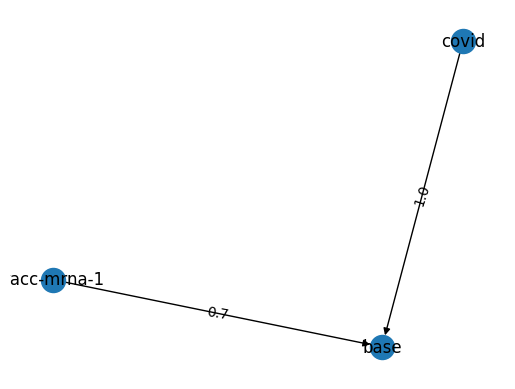

In [32]:
dataset_generator.draw_graph()

Now generate the second and third vaccinations with different probablitiies. They all need to depend on the previous vaccinations and the patient.

In [33]:
# second shot
second_vax_params = GeneratorParameters(
    field_values=[
        FieldValue(field="vaccineCode", value=Codes.COVID_VACC_RNA.value),
        FieldValue(field="status", value="completed"),
    ],
    field_generators=[vaccination_date_generator],
)
second_vaccination_generator = ResourceGenerator(
    "Immunization", generator_parameters=second_vax_params
)

dataset_generator = dataset_generator.add_resource_generator(
    second_vaccination_generator,
    "vacc-mrna-2",
    depends_on=["base", "vacc-mrna-1"],
    likelihood=0.9,
    reference_field=["patient", None],
)



In [34]:
# third shot
second_vax_params = GeneratorParameters(
    field_values=[
        FieldValue(field="vaccineCode", value=Codes.COVID_VACC_RNA.value),
        FieldValue(field="status", value="completed"),
    ],
    field_generators=[vaccination_date_generator],
)
third_vaccination_generator = ResourceGenerator(
    "Immunization", generator_parameters=second_vax_params
)

dataset_generator = dataset_generator.add_resource_generator(
    third_vaccination_generator,
    "vacc-mrna-3",
    depends_on=["base", "vacc-mrna-1", "vacc-mrna-2"],
    reference_field=["patient", None, None],
    likelihood=0.8,
)

Now lets look at the graph again

<module 'matplotlib.pyplot' from 'C:\\Users\\Michael Graf\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\fhir-kindling-aPmNxlUm-py3.11\\Lib\\site-packages\\matplotlib\\pyplot.py'>

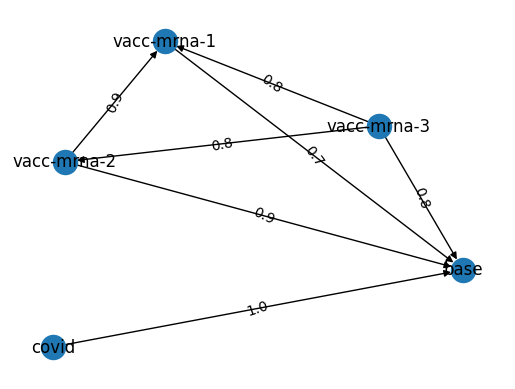

In [35]:
dataset_generator.draw_graph()

Generate an emergency room encounter

In [36]:
emergency_encounter_period_generator = FieldGenerator(
    field="period",
    generator_function=lambda: {
        "start": pendulum.now().subtract(days=730).to_date_string(),
        "end": pendulum.now().subtract(days=729).to_date_string(),
    },
)

# emergency encounter
emergency_encounter_params = GeneratorParameters(
    field_values=[
        FieldValue(field="class", value=Codes.EMERGENCY_ENCOUNTER.value),
        FieldValue(field="status", value="finished"),
    ],
    field_generators=[emergency_encounter_period_generator],
)

emergency_encounter_generator = ResourceGenerator(
    "Encounter", generator_parameters=emergency_encounter_params
)

dataset_generator = dataset_generator.add_resource_generator(
    emergency_encounter_generator,
    "emergency-encounter",
    depends_on="base",
    reference_field="subject",
)

and and ICU encounter

In [37]:
icu_encounter_period_generator = FieldGenerator(
    field="period",
    generator_function=lambda: {
        "start": pendulum.now().subtract(days=720).to_date_string(),
        "end": pendulum.now().subtract(days=710).to_date_string(),
    },
)

# icu encounter
icu_encounter_params = GeneratorParameters(
    field_values=[
        FieldValue(field="class", value=Codes.ICU_ENCOUNTER.value),
        FieldValue(
            field="type", value=Codes.ICU_ENCOUNTER_TYPE.value, list_field=True
        ),
        FieldValue(field="status", value="finished"),
    ],
    field_generators=[icu_encounter_period_generator],
)

icu_encounter_generator = ResourceGenerator(
    "Encounter", generator_parameters=icu_encounter_params
)

dataset_generator = dataset_generator.add_resource_generator(
    icu_encounter_generator,
    "icu-encounter",
    depends_on=["base", "emergency-encounter"],
    reference_field=["subject", None],
)

<module 'matplotlib.pyplot' from 'C:\\Users\\Michael Graf\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\fhir-kindling-aPmNxlUm-py3.11\\Lib\\site-packages\\matplotlib\\pyplot.py'>

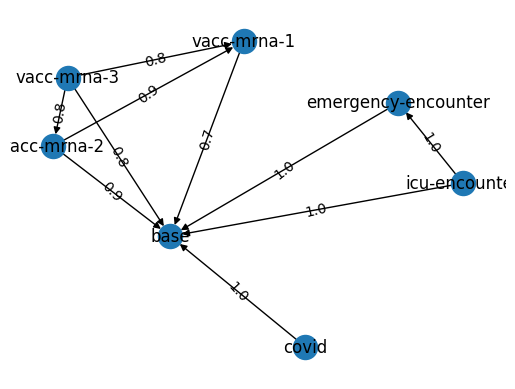

In [38]:
dataset_generator.draw_graph()

Now we generate some observations for the patient. We start with blood oxygen saturation as a time series generator

In [39]:
# blood oxygen saturation
blood_oxygen_params = GeneratorParameters(
    field_values=[
        FieldValue(field="code", value=Codes.OXYGEN_SATURATION.value),
        FieldValue(field="status", value="final"),
    ],
    field_generators=[
        FieldGenerator(
            field="valueQuantity",
            generator_function=lambda: {
                "value": random.randint(80, 100),
                "unit": "%",
            },
        ),
    ],
)
blood_oxygen_saturation_generator = ResourceGenerator(
    "Observation", generator_parameters=blood_oxygen_params
)

bo_time_series_generator = TimeSeriesGenerator(
    resource_generator=blood_oxygen_saturation_generator,
    start=pendulum.now().subtract(days=720),
    n=10,
    time_field="effectiveDateTime",
    freq="daily"
)

dataset_generator = dataset_generator.add_resource_generator(
    bo_time_series_generator,
    "blood-oxygen-saturation",
    depends_on="base",
    reference_field="subject",
)

Body temperature

In [40]:
# body temperature
body_temperature_params = GeneratorParameters(
    field_values=[
        FieldValue(field="code", value=Codes.BODY_TEMPERATURE.value),
        FieldValue(field="status", value="final"),
    ],
    field_generators=[
        FieldGenerator(
            field="valueQuantity",
            generator_function=lambda: {
                "value": random.randint(36, 40) + random.random(),
                "unit": "°C",
            },
        ),
    ],
)

body_temperature_generator = ResourceGenerator(
    "Observation", generator_parameters=body_temperature_params
)

dataset_generator = dataset_generator.add_resource_generator(
    body_temperature_generator,
    "body-temperature",
    depends_on="icu-encounter",
    reference_field="encounter",
)

respiratory rate

In [41]:
# respiratory rate
respiratory_rate_params = GeneratorParameters(
    field_values=[
        FieldValue(field="code", value=Codes.RESPIRATORY_RATE.value),
        FieldValue(field="status", value="final"),
    ],
    field_generators=[
        FieldGenerator(
            field="valueQuantity",
            generator_function=lambda: {
                "value": random.randint(12, 30),
                "unit": "breaths/min",
            },
        ),
    ],
)

respiratory_rate_generator = ResourceGenerator(
    "Observation", generator_parameters=respiratory_rate_params
)

dataset_generator = dataset_generator.add_resource_generator(
    respiratory_rate_generator,
    "respiratory-rate",
    depends_on="icu-encounter",
    reference_field="encounter",
)

heart rate

In [42]:
heart_rate_params = GeneratorParameters(
    field_values=[
        FieldValue(field="code", value=Codes.HEART_RATE.value),
        FieldValue(field="status", value="final"),
    ],
    field_generators=[
        FieldGenerator(
            field="valueQuantity",
            generator_function=lambda: {
                "value": random.randint(60, 100),
                "unit": "beats/min",
            },
        ),
    ],
)

heart_rate_generator = ResourceGenerator(
    "Observation", generator_parameters=heart_rate_params
)

dataset_generator = dataset_generator.add_resource_generator(
    heart_rate_generator,
    name="heart-rate",
    depends_on="icu-encounter",
    reference_field="encounter",
)

With this we are done for now and can look at the graph again

<module 'matplotlib.pyplot' from 'C:\\Users\\Michael Graf\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\fhir-kindling-aPmNxlUm-py3.11\\Lib\\site-packages\\matplotlib\\pyplot.py'>

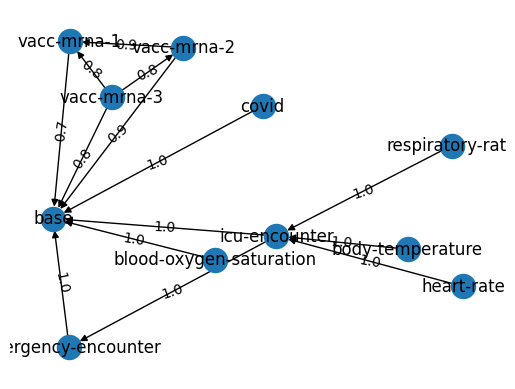

In [43]:
dataset_generator.draw_graph()

Now we can actually use the dataset generator to generate data

In [48]:
dataset = dataset_generator.generate(display=True)

Generating dataset:   0%|          | 0/10 [00:00<?, ?it/s]

In [49]:
dataset.n_resources

183

## Upload the dataset to a server

In [50]:
res = dataset.upload(server, display=True)

  0%|          | 0/183 [00:00<?, ?it/s]

In [51]:
covid_query = server.query("Patient").has(
    resource="Condition",
    search_param="code",
    operator="eq",
    value="RA01.0",
    reference_param="subject",
).include(
    resource="Condition",
    reference_param="subject",
    reverse=True
)

covid_response = covid_query.all()
covid_response

<QueryResponse(resource=Patient, n=20)>

# Transferring resources from one server to another

Use the `transfer()` function on a server object to transfer resources from one server to another while keeping referential integrity and using server assigned IDs.  


The transfer is a three-step process:
1. Analyze the resources to be transferred and build a DAG modeling the references
2. Obtain any missing resources that are referenced from the source server
3. Upload the resources to the target server based on the reference DAG
4. Generate a record linkage dictionary that links the transfered remsources

## Resources form a reference graph

![FHIR Kindling](assets/resource_graphs.png)


## Which gets resolved step by step
![FHIR Kindling](assets/upload_graph.png)

### Connect to an additional server and transfer based on the query

In [52]:
# define a new server
transfer_api_url = "http://localhost:9091/fhir"
transfer_server = FhirServer(api_address=transfer_api_url)

server.transfer(transfer_server, query=covid_query, display=True)

  0%|          | 0/40 [00:00<?, ?it/s]

<TransferResponse(origin_server=http://localhost:9090/fhir, destination_server=http://localhost:9091/fhir)

# Benchmarking

Benchmarks for clients (to see if the library is faster :)) as well as generalizable tools to benchmark the performance of FHIR servers.

## Client benchmark
![FHIR Kindling](assets/query_plot.png)

## Server Benchmark

Compare the performance of multiple FHIR servers on standard CRUD operations as well as search
- Create
- Batch Create
- Search
- Delete

The benchmarking tool will generate the same synthetic data that we created before and insert the resources into each server.
The created resources are tracked and removed at the end.

### Compare the three most common fhir servers
- Blaze
- Hapi
- Linux4Health

In [53]:
servers = [
    {"name": "blaze", "api_address": "http://localhost:9090/fhir"},
    {"name": "hapi", "api_address": "http://localhost:9091/fhir"},
    {
        "name": "linux4h",
        "api_address": "http://localhost:9080/fhir-server/api/v4/",
        "credentials": {"username": "fhiruser", "password": "change-password"},
    },
]


### Setup the servers

In [54]:
benchmark_servers = []
for s in servers:
    print(f"initializing Server {s['name']} -- {s['api_address']}")
    credentials = s.get("credentials", None)
    if credentials:
        benchmark_servers.append(
            FhirServer(
                api_address=s["api_address"],
                **credentials,
            )
        )
    else:
        benchmark_servers.append(FhirServer(api_address=s["api_address"]))

initializing Server blaze -- http://localhost:9090/fhir
initializing Server hapi -- http://localhost:9091/fhir
initializing Server linux4h -- http://localhost:9080/fhir-server/api/v4/


### Configure the benchmark

In [58]:
from fhir_kindling.benchmark import ServerBenchmark
benchmark = ServerBenchmark(
    servers=benchmark_servers,
    server_names=[s["name"] for s in servers],
    dataset_size=100,
    n_attempts=2,
)



### Run the test suite

In [ ]:
benchmark.run_suite()
figure = benchmark.plot()
figure.show()

Generating dataset:   0%|          | 0/100 [00:00<?, ?it/s]

Running bechmarks for 3 servers:: 0it [00:00, ?it/s]

Server http://localhost:9090/fhir:   0%|          | 0/7 [00:00<?, ?it/s]

Server http://localhost:9091/fhir:   0%|          | 0/7 [00:00<?, ?it/s]

### How to use & customize the benchmark


##### Test the performance of the servers on a new vm

1. Clone & install the library
2. Navigate into the benchmarks folder
3. Start the compose file containing the three servers `docker compose up`
4. Run the preconfigured benchmark script `python benchmark_servers.py`

#### Add custom queries for specific pain points
You can customize the queries to be tracked by providing `custom_queries` to the server benchmarks.
You can also configure which steps should be run by providing a list of steps:

### Custom benchmark

In [ ]:
benchmark = ServerBenchmark(
    servers=benchmark_servers,
    server_names=[s["name"] for s in servers],
    dataset_size=100,
    n_attempts=3,
    steps=["search"],
    custom_query
)

## Outlook

- Optimizations for handling large amounts of data
- Stable 1.0 release soon

### Privacy Methods
- use automatic tabular serialization to evaluate bundle responses with methods like k-anonymity
- automatic anonymization of fields (i.e. rounding dates to the year recoreded)

### User interface
- Graphical userinterface to create, save and execute queries
- Autocomplete for resources and their fields

<center><h2>Questions?</h2></center>


<center><h2>Feature requests, contributions and 🌟 are very welcome!</h2></center>